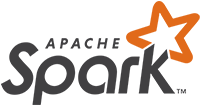

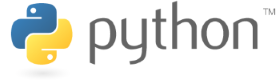


#  Welcome to Apache Spark with Python


>Apache Spark is a fast and general-purpose cluster computing system. It provides high-level APIs in Java, Scala, Python and R, and an optimized engine that supports general execution graphs. It also supports a rich set of higher-level tools including Spark SQL for SQL and structured data processing, MLlib for machine learning, GraphX for graph processing, and Spark Streaming.

   * http://spark.apache.org/

In this notebook, we'll train two classifiers to predict survivors in the Titanic dataset. We'll use this classic machine learning problem as a brief introduction to using Apache Spark local mode in a notebook.

In [3]:
import pyspark  
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithSGD
from pyspark.mllib.tree import DecisionTree

First we create a SparkContext, the main object in the Spark API. This call may take a few seconds to return as it fires up a JVM under the covers.

In [4]:
sc = pyspark.SparkContext()

## Sample the data

We point the context at a CSV file on disk. The result is a RDD, not the content of the file. This is a Spark transformation.

In [5]:
raw_rdd = sc.textFile("titanic.csv")

In [7]:
raw_rdd.count()

1317

We query for the first five rows of the RDD. Even though the data is small, we shouldn't get into the habit of pulling the entire dataset into the notebook. Many datasets that we might want to work with using Spark will be much too large to fit in memory of a single machine.

In [11]:
raw_rdd.take(5)

['"","class","age","sex","survived"',
 '"1","1st class","adults","man","yes"',
 '"2","1st class","adults","man","yes"',
 '"3","1st class","adults","man","yes"',
 '"4","1st class","adults","man","yes"']

We see a header row followed by a set of data rows. We filter out the header to define a new RDD containing only the data rows.

In [12]:
header = raw_rdd.first()
data_rdd = raw_rdd.filter(lambda line: line != header)

We take a random sample of the data rows to better understand the possible values

In [13]:
data_rdd.takeSample(False, 5, 0)

['"159","1st class","adults","man","no"',
 '"256","1st class","adults","women","yes"',
 '"1204","3rd class","adults","women","no"',
 '"758","3rd class","adults","man","no"',
 '"730","3rd class","adults","man","no"']

We see that the first value in every row is a passenger number. The next three values are the passenger attributes we might use to predict passenger survival: ticket class, age group, and gender. The final value is the survival ground truth.

## Create labeled points (i.e., feature vectors and ground truth)

Now we define a function to turn the passenger attributions into structured LabeledPoint objects.

In [15]:
def row_to_labeled_point(line):
    '''
    Builds a LabelPoint consisting of:
    
    survival (truth): 0=no, 1=yes
    ticket class: 0=1st class, 1=2nd class, 2=3rd class
    age group: 0=child, 1=adults
    gender: 0=man, 1=woman
    '''
    passenger_id, klass, age, sex, survived = [segs.strip('"') for segs in line.split(',')]
    klass = int(klass[0]) - 1
    
    if (age not in ['adults', 'child'] or 
        sex not in ['man', 'women'] or
        survived not in ['yes', 'no']):
        raise RuntimeError('unknown value')
    
    features = [
        klass,
        (1 if age == 'adults' else 0),
        (1 if sex == 'women' else 0)
    ]
    return LabeledPoint(1 if survived == 'yes' else 0, features)

We apply the function to all rows.

In [16]:
labeled_points_rdd = data_rdd.map(row_to_labeled_point)

We take a random sample of the resulting points to inspect them.

In [17]:
labeled_points_rdd.takeSample(False, 5, 0)

[LabeledPoint(0.0, [0.0,1.0,0.0]),
 LabeledPoint(1.0, [0.0,1.0,1.0]),
 LabeledPoint(0.0, [2.0,1.0,1.0]),
 LabeledPoint(0.0, [2.0,1.0,0.0]),
 LabeledPoint(0.0, [2.0,1.0,0.0])]

### Split for training and test

We split the transformed data into a training (70%) and test set (30%), and print the total number of items in each segment.

In [18]:
training_rdd, test_rdd = labeled_points_rdd.randomSplit([0.7, 0.3], seed = 0)

In [19]:
training_count = training_rdd.count()
test_count = test_rdd.count()

In [20]:
training_count, test_count

(914, 402)

## Train and test a decision tree classifier

Now we train a DecisionTree model. We specify that we're training a boolean classifier (i.e., there are two outcomes). We also specify that all of our features are categorical and the number of possible categories for each.

In [27]:
model = DecisionTree.trainClassifier(training_rdd, 
                                     numClasses=2, 
                                     categoricalFeaturesInfo={
                                        0: 3,
                                        1: 2,
                                        2: 2
                                     })

We now apply the trained model to the feature values in the test set to get the list of predicted outcomines.

In [28]:
predictions_rdd = model.predict(test_rdd.map(lambda x: x.features))

We bundle our predictions with the ground truth outcome for each passenger in the test set.

In [31]:
truth_and_predictions_rdd = test_rdd.map(lambda lp: lp.label).zip(predictions_rdd)

Now we compute the test error (% predicted survival outcomes == actual outcomes) and display the decision tree for good measure.

In [32]:
accuracy = truth_and_predictions_rdd.filter(lambda v_p: v_p[0] == v_p[1]).count() / float(test_count)
print('Accuracy =', accuracy)
print(model.toDebugString())

Accuracy = 0.7985074626865671
DecisionTreeModel classifier of depth 4 with 21 nodes
  If (feature 2 in {0.0})
   If (feature 1 in {0.0})
    If (feature 0 in {0.0,1.0})
     Predict: 1.0
    Else (feature 0 not in {0.0,1.0})
     Predict: 0.0
   Else (feature 1 not in {0.0})
    If (feature 0 in {1.0})
     Predict: 0.0
    Else (feature 0 not in {1.0})
     If (feature 0 in {0.0})
      Predict: 0.0
     Else (feature 0 not in {0.0})
      Predict: 0.0
  Else (feature 2 not in {0.0})
   If (feature 0 in {2.0})
    If (feature 1 in {0.0})
     Predict: 0.0
    Else (feature 1 not in {0.0})
     Predict: 0.0
   Else (feature 0 not in {2.0})
    If (feature 0 in {1.0})
     If (feature 1 in {0.0})
      Predict: 1.0
     Else (feature 1 not in {0.0})
      Predict: 1.0
    Else (feature 0 not in {1.0})
     If (feature 1 in {0.0})
      Predict: 1.0
     Else (feature 1 not in {0.0})
      Predict: 1.0



## Train and test a logistic regression classifier

In [37]:
model = LogisticRegressionWithSGD.train(training_rdd)

/usr/local/spark/python/pyspark/mllib/classification.py:313: UserWarning: Deprecated in 2.0.0. Use ml.classification.LogisticRegression or LogisticRegressionWithLBFGS.
  "Deprecated in 2.0.0. Use ml.classification.LogisticRegression or "


In [38]:
predictions_rdd = model.predict(test_rdd.map(lambda x: x.features))

In [39]:
labels_and_predictions_rdd = test_rdd.map(lambda lp: lp.label).zip(predictions_rdd)

In [40]:
accuracy = labels_and_predictions_rdd.filter(lambda v_p: v_p[0] == v_p[1]).count() / float(test_count)
print('Accuracy =', accuracy)

Accuracy = 0.7860696517412935


The two classifiers show similar accuracy. More information about the passengers could definitely help improve this metric.